<b>Note:</b> This is a testing notebook for LSTM Model.

## Step 1: *Import Libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

## Step 2: *Import Data*

> Data was taken from [Kaggle](https://www.kaggle.com/code/farzadnekouei/gold-price-prediction-lstm-96-accuracy)

In [2]:
import yfinance as yf
start = '2010-01-01'
end = '2024-01-01'
stock = 'XAUT-USD'
data = yf.download(stock, start, end)
data.reset_index(inplace = True)

[*********************100%%**********************]  1 of 1 completed


## Step 3: Exploratory Data Analysis (EDA)

### Step 3.1: Data Overview

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865,1581.786865,1305750
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751,1578.869751,1609288
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271,1578.702271,575041
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547,1572.435547,123025
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325,1563.408325,340994
...,...,...,...,...,...,...,...
1419,2023-12-27,2067.487061,2083.567383,2063.218018,2074.964355,2074.964355,4770225
1420,2023-12-28,2075.123047,2087.295654,2066.581787,2072.599121,2072.599121,4990665
1421,2023-12-29,2072.603760,2078.412354,2060.760742,2068.144775,2068.144775,5308010
1422,2023-12-30,2068.159912,2069.790527,2060.790771,2067.288574,2067.288574,5317621


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1424 non-null   datetime64[ns]
 1   Open       1424 non-null   float64       
 2   High       1424 non-null   float64       
 3   Low        1424 non-null   float64       
 4   Close      1424 non-null   float64       
 5   Adj Close  1424 non-null   float64       
 6   Volume     1424 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.0 KB


### Step 3.2: Check for duplicated value in *dataset*

In [5]:
data.duplicated().sum()

0

### Step 3.3: Check for null value in dataset

In [6]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

> As you can see, the data is stored as object and there is a null value in the data. This is not a concern since we can transform the data type and will not be using *Vol.* variable.

## Step 4: Data Processing

> As said before, we will be droping both *'Vol.'* and *'Change %'* since we didn't need them.

### Step 4.1: Feature Selection

In [7]:
data.drop(['Adj Close', 'Volume'], axis = 1, inplace = True)
data.head()

,Date,Open,High,Low,Close
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325


### Step 4.2: Transforming Data Types

> Since the data was stored as object, we need to change these variables to their correct data types.

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending =  True, inplace = True)
data.reset_index(drop = True, inplace = True)

> The ' , ' in the dataset is redundant and need to be removed from the entire dataset and change their variables to *float*

In [9]:
NumCols = data.columns.drop(['Date'])
data[NumCols] = data[NumCols].replace({',' : ''}, regex = True)
data[NumCols] = data[NumCols].astype('float64')

> ***result :***

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1424 non-null   datetime64[ns]
 1   Open    1424 non-null   float64       
 2   High    1424 non-null   float64       
 3   Low     1424 non-null   float64       
 4   Close   1424 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 55.8 KB


In [11]:
data.head()

,Date,Open,High,Low,Close
0,2020-02-07,1582.213135,1585.620361,1576.241089,1581.786865
1,2020-02-08,1581.844116,1587.325439,1567.624634,1578.869751
2,2020-02-09,1578.880005,1590.733154,1572.618164,1578.702271
3,2020-02-10,1579.318970,1594.563721,1560.719360,1572.435547
4,2020-02-11,1572.398926,1617.188721,1546.927002,1563.408325


## Step 5: Visualizing Data

In [12]:
fig = px.line(y=data.Close, x=data.Date)
fig.update_traces(line_color='rgba(255,223,0,0.8)')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='black')


## Step 6: Splitting Data to Training & Test Sets

> Since we are using LSTM, which is a time-series model, we should not randomly split the data. In time-series splitting, testing set is always later than training set. As consideration, we followed the author using the last year for test set and the rest for training.

In [13]:
test_size = data[data.Date.dt.year == 2022].shape[0]
test_size

365

> Let's plot the training and testing set

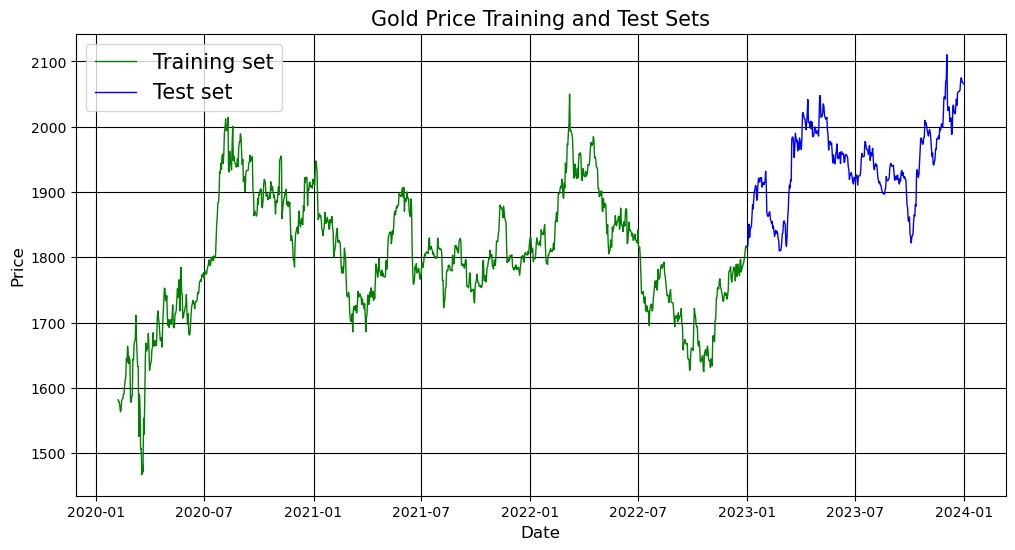

In [14]:
plt.figure(figsize=(12, 6), dpi=100)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='black')
plt.plot(data.Date[:-test_size], data.Close[:-test_size], color='green', lw=1)
plt.plot(data.Date[-test_size:], data.Close[-test_size:], color='blue', lw=1)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='black')
plt.show()

## Step 7: Data Scaling

> To avoid intensive computation, the author used > MinMaxScaler : $𝑋scaled = \frac{𝑋 - 𝑋min}{𝑋max - 𝑋min}$

In [15]:
scaler = MinMaxScaler()
scaler.fit(data.Close.values.reshape(-1, 1))

MinMaxScaler()

## Step 8: Restructure Data & Create Sliding Window

>
```
Sliding window = the use of prior time step to predict the next time step<br>
Window width = the number of previous time steps<br><br>
```
>In this way, we can express time series data as supervised learning. We can do this by using previous time steps as input variables and the next time steps as output variable. The window width used by the author is 60, which mean the X_train and X_test will be nested list containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively.

In [16]:
window_size = 60

### Training Set

In [17]:
train_data = data.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
  X_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

### Test Set

In [18]:
test_data = data.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
  X_test.append(test_data[i-60:i, 0])
  y_test.append(test_data[i, 0])

## Step 9: Converting Data to Numpy Arrays

> Now X_train and X_test are nested lists (two-dimensional lists) and y_train and y_test is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network

In [19]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1,1))

In [21]:
print('X_train Shape: ', X_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (999, 60, 1)
X_test Shape:  (365, 60, 1)
y_train Shape:  (999, 1)
y_test Shape:  (365, 1)


## Step 10: Creating a LSTM Network

> model definition:

In [22]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [23]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32,
                    validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.1450 - val_loss: 0.0125
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0087 - val_loss: 0.0066
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0076 - val_loss: 0.0052
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 9/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 10/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 11/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 12/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

In [24]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1582e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [25]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [26]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00044918281491845846
Test MAPE: 0.020771959968959176
Test Accuracy: 0.9792280400310408


In [27]:
#RMSE Calculation
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", rmse*100, "%")

Root Mean Squared Error:  2.1193934200662663 %


In [28]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

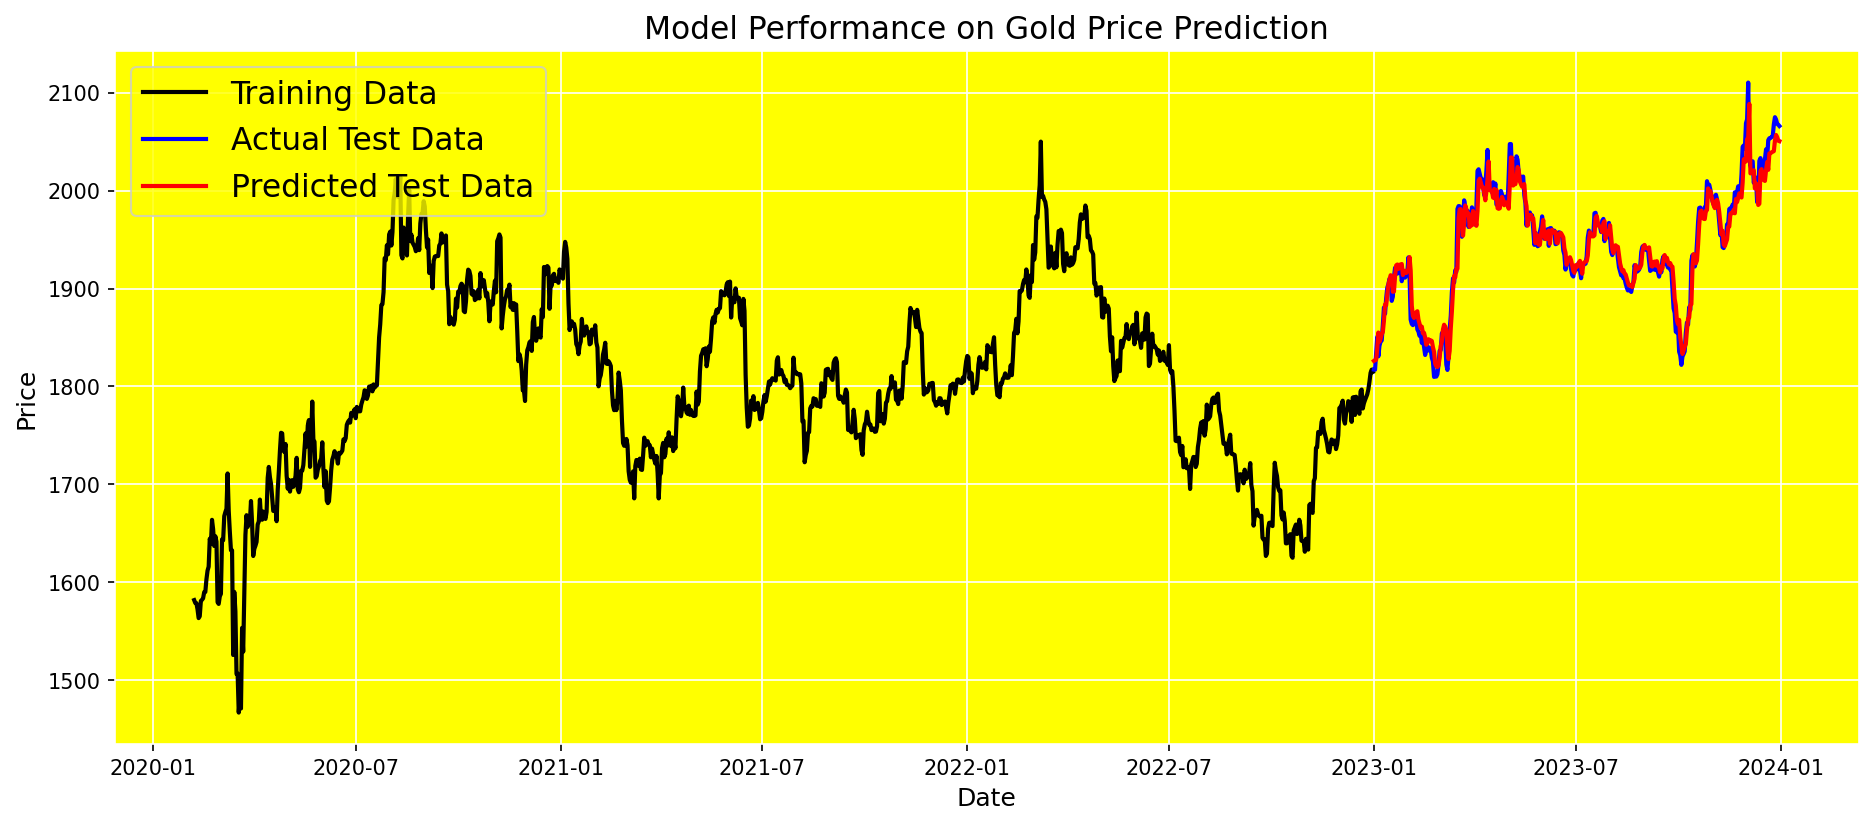

In [29]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(data['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(data['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(data['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [30]:
model.save('/Users/LEGION/Downloads/Stock_Market_Prediction_ML (1)/Gold-price-prediction.keras')